## Load Packages and Preprae data

In [1]:
#!/bin/bash/

# coding: utf-8

import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score

import sys


package_path = '/public/ysun43/deeplearning/EfficientNet-PyTorch/'
pp_apex = "/public/ysun43/deeplearning/"
sys.path.append(package_path)
sys.path.append(pp_apex)
# pp_apex = "/public/ysun43/deeplearning/nvidiaapex/"
# sys.path.insert(0, pp_apex)
from efficientnet_pytorch import EfficientNet
# sys.path.insert(0, '/software/anaconda3/2018.12/lib/python3.7/site-packages')
# sys.path.insert(0, '/software/anaconda3/2018.12/lib/python3.7/site-packages/IPython/extensions')

# from apex import amp
# from tqdm import tqdm_notebook as tqdm
# import seaborn as sns


import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # Plotting
# import seaborn as sns # Plotting

# Import Image Libraries - Pillow and OpenCV
from PIL import Image
import cv2

# Import PyTorch and useful fuctions
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torch.optim as optim
import torchvision.models as models # Pre-Trained models

# Import useful sklearn functions

import time
import os
import random


# In[76]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

# In[99]:


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_no = 42
seed_everything(seed_no)
num_classes = 1
IMG_SIZE    = 256


# In[4]:
def gpu_basic():
    print()

# os.listdir("/public/ysun43/deeplearning/EfficientNet-PyTorch/")


# In[102]:



out_name = ""

device:  cpu


## data split

In [2]:

# ## data split



data_base_dir = "/home/yduan14/dsc481_finalProject/"

train_2019 = pd.read_csv(os.path.join(data_base_dir,"inputs/df_2019_train.csv"))
train_2015 = pd.read_csv(os.path.join(data_base_dir,"inputs/df_2015_train.csv"))


# train_2019 only
# train_2015+train_2015: 9:1 split 
# train_2015:pretrained + train_2019:finetune
# data_split: df2019; df_1519; df_15pre_19fine
train_2019['set']=1
train_2015['set']=0

temp = pd.DataFrame()
temp = temp.append(train_2015)
temp = temp.append(train_2019)

# data_split = "df_1519"
#data_split = "df2019"
data_split = "df_15pre_19fine"
if data_split == "df2019":
    train_df = train_2019.loc[~train_2019['is_valid1'], :]
    val_df = train_2019.loc[train_2019['is_valid1'], :]
elif data_split == "df_1519":
    train_df = temp.loc[~temp['is_valid1'], :]
    val_df = temp.loc[temp['is_valid1'], :]
elif data_split =='df_15pre_19fine':
    train_df = train_2015.loc[~train_2015['is_valid1'], :]
    val_df = train_2015.loc[train_2015['is_valid1'], :]

print(train_df.shape)
print(val_df.shape)
print(train_df.sample(50).shape)
#train_df = train_df.sample(20)
#val_df = val_df.sample(20)

train_df.shape
train_df.head(2)
val_df.shape
train_df.head(2)
train_df.set.value_counts()
val_df.set.value_counts()



(28084, 9)
(7024, 9)
(50, 9)


(28084, 9)

,id_code,diagnosis,path,is_valid1,is_valid2,is_valid3,is_valid4,is_valid5,set
6777,8515_right,2,/public/ysun43/diabetic-retinopathy-resized/re...,False,True,False,False,False,0
6782,8522_left,2,/public/ysun43/diabetic-retinopathy-resized/re...,False,True,False,False,False,0


(7024, 9)

,id_code,diagnosis,path,is_valid1,is_valid2,is_valid3,is_valid4,is_valid5,set
6777,8515_right,2,/public/ysun43/diabetic-retinopathy-resized/re...,False,True,False,False,False,0
6782,8522_left,2,/public/ysun43/diabetic-retinopathy-resized/re...,False,True,False,False,False,0


0    28084
Name: set, dtype: int64

0    7024
Name: set, dtype: int64

### obtain balanced data 

In [9]:
temp = pd.DataFrame()
temp = temp.append(train_2019.copy())
temp = temp.append(train_2015.query("diagnosis==3").sample(810).copy())
temp = temp.append(train_2015.query("diagnosis==4").sample(708).copy())
temp = temp.append(train_2015.query("diagnosis==1").sample(633).copy())
temp = temp.append(train_2015.query("diagnosis==2").sample(4).copy())

temp.to_csv("/home/yduan14/dsc481_finalProject/balanced_data.csv", index =None)

temp.to_csv("/public/ysun43/deeplearning/balanced_data.csv", index =None)

sys.path.insert(0, '/software/anaconda3/2018.12/lib/python3.7/site-packages')

In [56]:
import seaborn as sns

def plot_label(data,label):
    """
    input:
    data(data_frame): the input dataframe 
    label(str): the labels to be plotted
    
    output:
    barplot of label distributions
    """
    labels = data[label].value_counts()
    class_list = ['No DR_0', 'Mild_1', 'Moderate_2', 'Severe_3', 'Proliferate_4']
    for idx,val in enumerate(class_list):
        labels[val] = labels.pop(idx)
    plt.figure(figsize = (16,8))
    sns.barplot(labels.index, labels.values, alpha = 0.8, palette = 'viridis')
    plt.title('Distribution of label classes')
    plt.ylabel("Number of occurrences", fontsize = 12)
    plt.xlabel("Target classes",fontsize = 12)
    plt.legend()
    plt.savefig("./label_distribution.png")
    plt.show()
    
def label_percentage(data, label):
    labels = pd.DataFrame(data[label].value_counts().sort_values(ascending = False))
    labels["percent"] = labels[label].apply(lambda x: 100*x / sum(labels[label].values))
    return (labels)

In [ ]:
plot_label(temp, "diagnosis")

In [73]:
# percentage for each category on 2015 dataset and 2019 dataset 
label_percentage(train_2015.append(train_2019), "diagnosis")
label_percentage(train_2019, "diagnosis")
label_percentage(temp, "diagnosis")

,diagnosis,percent
0,27607,71.207119
2,6287,16.216147
1,2808,7.242713
3,1065,2.746969
4,1003,2.587052


,diagnosis,percent
0,1805,49.290005
2,999,27.280175
1,370,10.103768
4,295,8.055707
3,193,5.270344


## Transform methods and visulization 

- RandomRotation((-120, 120))
- RandomAffine(degrees=(-180, 180), scale=(0.8889, 1.0), shear=(-36, 36))
- RandomHorizontalFlip(p=0.5)
- RandomVerticalFlip(p=0.5)
- ColorJitter(brightness=0, contrast=(0.9, 1.1), saturation=0, hue=0)

In [11]:
train_transforms = transforms.Compose([
    # transforms.ToPILImage(),
#     transforms.Resize((224, 224)),
    transforms.RandomRotation((-120, 120)),
    transforms.RandomAffine(
        degrees=(-180, 180),
        scale=(0.8889, 1.0),
        shear=(-36, 36),
    ),
#     transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.ColorJitter(
        brightness=0,
        contrast=(0.9, 1.1),
        saturation=0,
        hue=0),
])

In [6]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

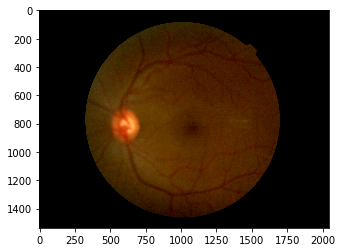

In [7]:
path_img = train_2019.loc[4, 'path']
sample = Image.open(path_img)
# plt.imshow(sample)
img = Image.open(path_img).convert('RGB')     # 0~255
plt.imshow(img)

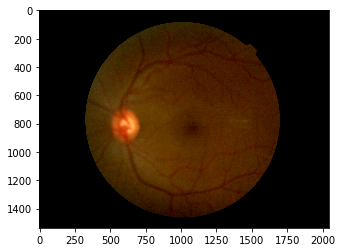

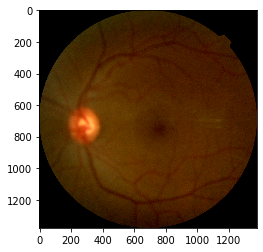

In [8]:
# crop_image_from_gray
import cv2

image = cv2.imread(train_2019.loc[4, 'path'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
image = crop_image_from_gray(image)
plt.imshow(image)
plt.show()

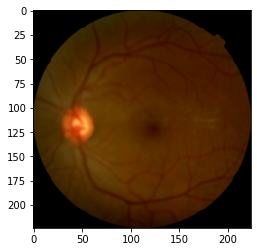

In [9]:
img = image

img = transforms.ToPILImage()(img)

img = transforms.Resize((224, 224))(img)
plt.imshow(img)

In [12]:
print(train_transforms.transforms[0])

RandomRotation(degrees=(-120, 120), resample=False, expand=False)


transform method:  RandomRotation(degrees=(-120, 120), resample=False, expand=False)


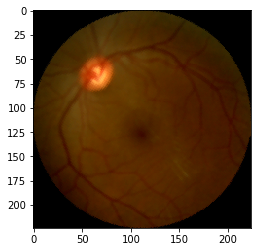

transform method:  RandomAffine(degrees=(-180, 180), scale=(0.8889, 1.0), shear=[-36, 36, 0.0, 0.0])


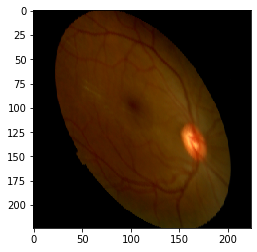

transform method:  RandomHorizontalFlip(p=1)


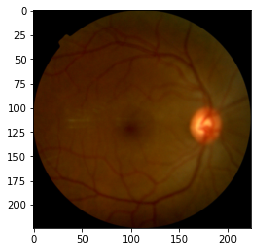

transform method:  RandomVerticalFlip(p=1)


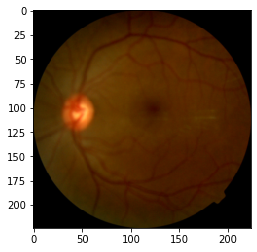

transform method:  ColorJitter(brightness=None, contrast=(0.9, 1.1), saturation=None, hue=None)


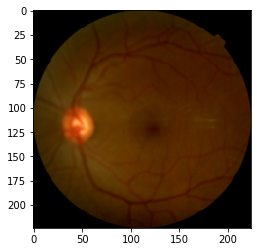

In [155]:
for tr in train_transforms.transforms:
    print("transform method: ", tr)
    plt.imshow(tr(img))
    plt.show()